In [1]:
import sys
import os
import shutil
sys.path.insert(0, 'icenumerics/')

import pandas as pd
import numpy as np
import scipy.spatial as spa
import matplotlib.pyplot as plt
import matplotlib as mpl

import icenumerics as ice
from icenumerics.geometry import ordering 
import csv as csv
import time
import string as st
from multiprocessing import Pool

import copy as cp

ureg = ice.ureg

idx = pd.IndexSlice

import tqdm.auto as tqdm

%reload_ext autoreload
%autoreload 2

[-33.0 -0.0 -0.0] micrometer
[33.0 0.0 0.0] micrometer
[33.0 0.0 0.0] micrometer
[-33.0 -0.0 -0.0] micrometer
[-33.0 -0.0 -0.0] micrometer
[33.0 0.0 0.0] micrometer
[-33.0 -0.0 -0.0] micrometer
[-33.0 -0.0 -0.0] micrometer
[33.0 0.0 0.0] micrometer
[-33.0 -0.0 -0.0] micrometer
[33.0 0.0 0.0] micrometer
[33.0 0.0 0.0] micrometer
[33.0 0.0 0.0] micrometer
[33.0 0.0 0.0] micrometer
[-33.0 -0.0 -0.0] micrometer
[33.0 0.0 0.0] micrometer


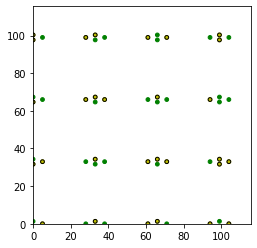

In [2]:
e = 1
l = 4

lattice_constant = 33*ureg.um
lattic_size = [l,l]
sp = ice.spins()
sp.create_lattice("square",[l,l],lattice_constant=33*ureg.um, border="periodic")
sp.order_spins(ordering.random_ordering)

sp.lattice
particle1 = ice.particle(radius = 1*ureg.um,
         susceptibility = 0.5,
         diffusion = 0.125*ureg.um**2/ureg.s,
         temperature = 300*ureg.K,
         density = 1000*ureg.kg/ureg.m**3)

trap1 = ice.trap(trap_sep = 23*ureg.um,
               height = 0.5*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)

particle2 = ice.particle(radius = 1*ureg.um,
         susceptibility = 0.0675,
         diffusion = 0.125*ureg.um**2/ureg.s,
         temperature = 300*ureg.K,
         density = 1000*ureg.kg/ureg.m**3)

trap2 = ice.trap(trap_sep = 30.3558*ureg.um,
               height = 0.5*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)

# <In this loop we are generating our bidisperse Ice>

traps = []
particles = []

for s in sp:

    if s.direction[1] == 0:
        print(s.direction)
        # Horizontal traps
        traps.append(trap1) 
        particles.append(particle1)
        pass

    else: 
        # Vertical traps
        traps.append(trap2) 
        particles.append(particle2) 


col = ice.colloidal_ice(sp, particles, traps , height_spread = 0.20 , susceptibility_spread = 0)
col.display()

In [3]:
v = ice.vertices()
v = v.colloids_to_vertices(col)

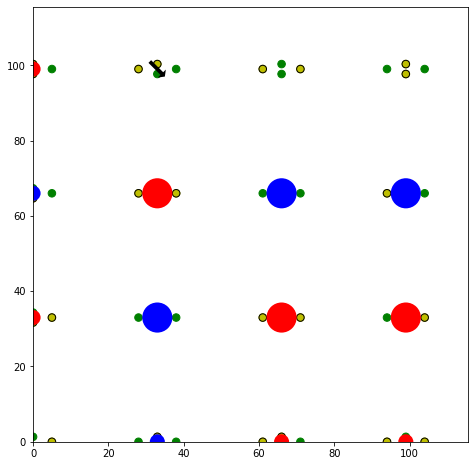

In [4]:
f, (ax1) = plt.subplots(1,1,figsize = (8,8))


col.display(ax1)
v.display(ax1)

In [5]:
col.region[:,:2]=(np.array([np.array([0,0]),lattic_size])-0.1)*lattice_constant
col.region[:,2] = np.array([-.11,.11])*ureg.um

world = ice.world(
    field = 30*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um,
    boundaries = ["p", "p", "p"])

total_time = 1000*ureg.s
col.simulation(world,
             name = "execute_test_l%u_exp%u"%(l,e),
             include_timestamp = False,
             targetdir = r".",
             framerate = 1*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = total_time,
             output = ["x","y","z","mux","muy","muz"])

col.sim.field.fieldz = "v_Bmag*time/%f"%total_time.to(ureg.us).magnitude
col.run_simulation()

In [6]:
col.load_simulation(slice(0,None,15))

In [7]:
col.trj

type             x          y    z   mux  muy  muz      t
frame id                                                           
0     1      1  1.939710e-15  31.677900  0.0   0.0  0.0  0.0    0.0
      2      1  3.300000e+01   1.322100  0.0   0.0  0.0  0.0    0.0
      3      1  6.600000e+01   1.322100  0.0   0.0  0.0  0.0    0.0
      4      1  9.900000e+01  31.677900  0.0   0.0  0.0  0.0    0.0
      5      1  1.939710e-15  64.677902  0.0   0.0  0.0  0.0    0.0
...        ...           ...        ...  ...   ...  ...  ...    ...
66    60     4  1.155000e+02  66.000000  0.0  23.0  0.0  0.0  990.0
      61     4  1.650000e+01  99.000000  0.0  23.0  0.0  0.0  990.0
      62     4  4.950000e+01  99.000000  0.0  23.0  0.0  0.0  990.0
      63     4  8.250000e+01  99.000000  0.0 -23.0 -0.0 -0.0  990.0
      64     4  1.155000e+02  99.000000  0.0  23.0  0.0  0.0  990.0

[4288 rows x 8 columns]

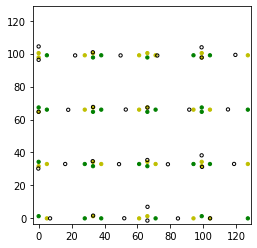

In [8]:
col.display()

In [9]:
trj_particle = col.trj[col.trj.type<=2]

In [10]:
mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 70

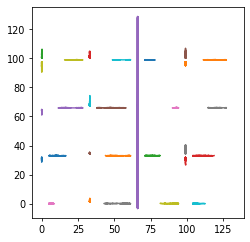

In [11]:
for i in trj_particle.index.get_level_values("id").unique():
    plt.plot(trj_particle.loc[idx[:,i],"x"],trj_particle.loc[idx[:,i],"y"])
plt.axis("square");

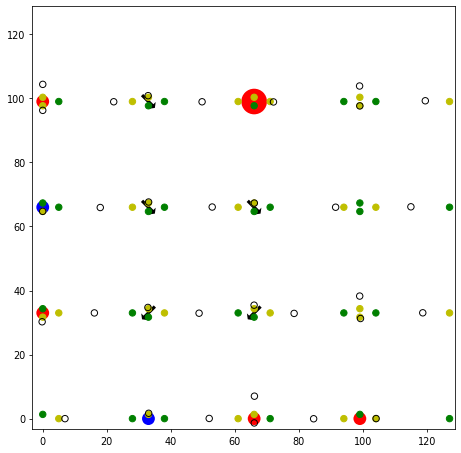

In [12]:
v = ice.vertices()
v = v.colloids_to_vertices(col)

f, (ax1) = plt.subplots(1,1,figsize = (8,8))
v.display(ax1)
col.display(ax1)

In [13]:
col.set_state_from_frame(66)
v = v.colloids_to_vertices(col)

# In the following function we will restore the information of the single particle spin. 

In [14]:
def single_particle_classification():
    
    spin_dir_pd = pd.DataFrame(data = v.neighbors,
                            index = v.neighbors,
                            columns = ["p1","p2","p3","p4"])

    for key in v.neighbors: #Iterates over the vertices of the system.
        #To reset the x, y and neigh value
        x = []
        y = []
        neigh = []

        for n in v.neighbors[key]: #Iterates over each spin of the vertex.

            # To classify by particle number we will filter by the center position of the trap respect to the other traps.
            neigh.append(n)
            x.append(v.spins[n]['Center'][0])
            y.append(v.spins[n]['Center'][1])

        # Vertices with coordination 3 are not well readed. 
        minx_neigh = np.argmin(x)
        maxx_neigh = np.argmax(x)
        miny_neigh = np.argmin(y)
        maxy_neigh = np.argmax(y)


        spin_dir_pd.loc[key, 'p1'] = v.spins[neigh[minx_neigh]]['Direction'][0]
        spin_dir_pd.loc[key, 'p3'] = v.spins[neigh[maxx_neigh]]['Direction'][0]
        spin_dir_pd.loc[key, 'p2'] = v.spins[neigh[miny_neigh]]['Direction'][1]
        spin_dir_pd.loc[key, 'p4'] = v.spins[neigh[maxy_neigh]]['Direction'][1]  

    spin_dir_pd.index.name = 'id'
    result = pd.concat([v.DataFrame(), spin_dir_pd], axis = 1)
    return result

In [15]:
single_particle_classification()

,Coordination,Charge,DipoleX,DipoleY,LocationX,LocationY,p1,p2,p3,p4
id,,,,,,,,,,
0,3,-1,1.000000e+00,2.0,0.0,66.0,6.12323e-17,1,1,1
1,4,0,2.000000e+00,-2.0,33.0,99.0,1,-1,1,-1
2,3,1,1.000000e+00,0.0,0.0,99.0,6.12323e-17,1,1,-1
3,3,1,-1.000000e+00,2.0,0.0,33.0,6.12323e-17,1,-1,1
4,4,0,2.000000e+00,-2.0,33.0,66.0,1,-1,1,-1
5,3,1,6.123234e-17,1.0,99.0,0.0,1,-0,-1,1
6,4,0,-6.123234e-17,0.0,99.0,66.0,1,-1,-1,1
7,4,0,0.000000e+00,0.0,99.0,33.0,-1,1,1,-1
8,4,0,2.000000e+00,-2.0,66.0,66.0,1,-1,1,-1


In [16]:
result = pd.concat([v.DataFrame(), spin_dir_pd], axis = 1)

NameError: name 'spin_dir_pd' is not defined

In [ ]:
result

In [ ]:
v = ice.vertices()
v = v.colloids_to_vertices(col)

f, (ax1) = plt.subplots(1,1,figsize = (8,8))
v.display(ax1)
col.display(ax1)

In [ ]:
f, axes = plt.subplots(3,2,figsize = (20,20))
ax1, ax2, ax3, ax4, ax5,ax6 = axes.flatten()
i = 10
col.set_state_from_frame(0)
v = v.colloids_to_vertices(col)
field = 0/0.06667*300/8500
ax1.set_title(str(field))
col.display(ax1)
v.display(ax1)
col.set_state_from_frame(200)
v = v.colloids_to_vertices(col)
field1 = 200/0.06667*300/8500
ax2.set_title(str(field1))
col.display(ax2)
v.display(ax2)
col.set_state_from_frame(220)
v = v.colloids_to_vertices(col)
field2 = 220/0.06667*300/8500
ax3.set_title(str(field2))
col.display(ax3)
v.display(ax3)
col.set_state_from_frame(240)
v = v.colloids_to_vertices(col)
field3 = 240/0.06667*300/8500
ax4.set_title(str(field3))
col.display(ax4)
v.display(ax4)
col.set_state_from_frame(300)
v = v.colloids_to_vertices(col)
field4 = 300/0.06667*300/8500
ax5.set_title(str(field4))
col.display(ax5)
v.display(ax5)
col.set_state_from_frame(566)
v = v.colloids_to_vertices(col)                                
field5 = 566/0.06667*300/8500
ax6.set_title(str(field5))
col.display(ax6)
v.display(ax6)